# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

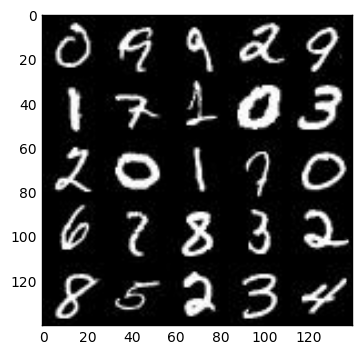

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

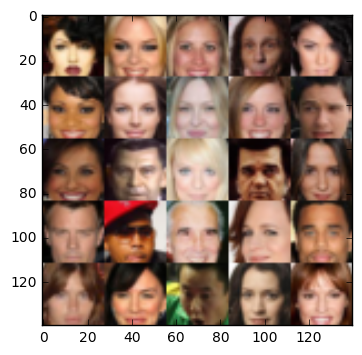

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, [None, z_dim], name='inputs_z')
    lr = tf.placeholder(tf.float32, None)

    return inputs_real, inputs_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # leaky_relu function
    def leaky_relu(x, alpha=0.2, name='leaky_relu'): 
        return tf.maximum(x, alpha * x, name=name)
    
    # Leaky parameter Alpha 
    alpha = 0.2

    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        # Leaky relu activation function
        relu1 = leaky_relu(x1, alpha, name='leaky_relu')
        # 16x16x64
        
        # Dropout "rate=0.2" would drop out 20% of input units
        drop = tf.layers.dropout(relu1, rate=0.2)
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = leaky_relu(bn2, alpha, name='leaky_relu')
        # 8x8x128
        
        # Dropout "rate=0.2" would drop out 20% of input units
        drop = tf.layers.dropout(relu2, rate=0.2)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = leaky_relu(bn3, alpha, name='leaky_relu')
        # 4x4x256
        
        # Dropout "rate=0.2" would drop out 20% of input units
        drop = tf.layers.dropout(relu3, rate=0.2)

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # leaky_relu function
    def leaky_relu(x, alpha=0.2, name='leaky_relu'): 
        return tf.maximum(x, alpha * x, name=name)
    
    # Leaky parameter Alpha 
    alpha = 0.2
    
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=False if is_train==True else True):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = leaky_relu(x1, alpha, name='leaky_relu')
        # 7x7x256 now
        
        # Dropout "rate=0.2" would drop out 20% of input units
        drop = tf.layers.dropout(x1, rate=0.2, training=is_train)
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = leaky_relu(x2, alpha, name='leaky_relu')
        # 14x14x128 now
        
        # Dropout "rate=0.2" would drop out 20% of input units
        drop = tf.layers.dropout(x2, rate=0.2, training=is_train)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1.0 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
     # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [14]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
        
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
        
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    steps = 0
    print_every = 10
    show_every = 100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                # rescale to pass to D
                batch_images *= 2.0
                
                # Get input noise
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                if steps % show_every == 0:
                    show_generator_output(sess, 10, input_z, data_shape[3], data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.5896... Generator Loss: 0.2707
Epoch 1/2... Discriminator Loss: 1.4246... Generator Loss: 0.5196
Epoch 1/2... Discriminator Loss: 2.7573... Generator Loss: 2.7260
Epoch 1/2... Discriminator Loss: 3.1920... Generator Loss: 3.3261
Epoch 1/2... Discriminator Loss: 1.2548... Generator Loss: 1.0842
Epoch 1/2... Discriminator Loss: 1.6646... Generator Loss: 0.8325
Epoch 1/2... Discriminator Loss: 1.5911... Generator Loss: 1.5953
Epoch 1/2... Discriminator Loss: 1.3874... Generator Loss: 1.2583
Epoch 1/2... Discriminator Loss: 1.5700... Generator Loss: 0.4345
Epoch 1/2... Discriminator Loss: 1.4343... Generator Loss: 1.0681


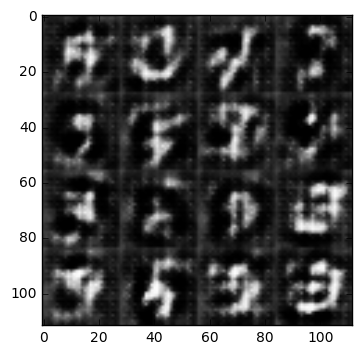

Epoch 1/2... Discriminator Loss: 1.6730... Generator Loss: 0.4238
Epoch 1/2... Discriminator Loss: 1.4481... Generator Loss: 0.5203
Epoch 1/2... Discriminator Loss: 1.2087... Generator Loss: 1.1319
Epoch 1/2... Discriminator Loss: 1.6950... Generator Loss: 0.3642
Epoch 1/2... Discriminator Loss: 1.6024... Generator Loss: 0.4388
Epoch 1/2... Discriminator Loss: 1.3251... Generator Loss: 0.6256
Epoch 1/2... Discriminator Loss: 1.3208... Generator Loss: 0.6883
Epoch 1/2... Discriminator Loss: 1.3066... Generator Loss: 1.2468
Epoch 1/2... Discriminator Loss: 1.3046... Generator Loss: 1.6285
Epoch 1/2... Discriminator Loss: 1.8061... Generator Loss: 2.3212


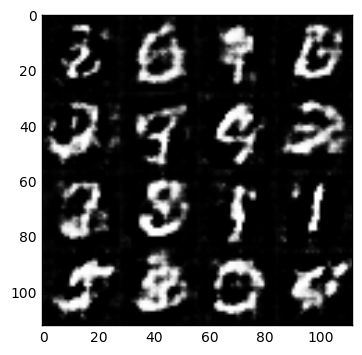

Epoch 1/2... Discriminator Loss: 1.3798... Generator Loss: 0.5524
Epoch 1/2... Discriminator Loss: 1.2170... Generator Loss: 1.3053
Epoch 1/2... Discriminator Loss: 1.2360... Generator Loss: 0.8659
Epoch 1/2... Discriminator Loss: 1.1692... Generator Loss: 1.1889
Epoch 1/2... Discriminator Loss: 1.3334... Generator Loss: 0.7830
Epoch 1/2... Discriminator Loss: 1.3065... Generator Loss: 1.3902
Epoch 1/2... Discriminator Loss: 1.3524... Generator Loss: 0.5564
Epoch 1/2... Discriminator Loss: 1.5535... Generator Loss: 0.4688
Epoch 1/2... Discriminator Loss: 1.1622... Generator Loss: 0.9236
Epoch 1/2... Discriminator Loss: 1.2790... Generator Loss: 0.6252


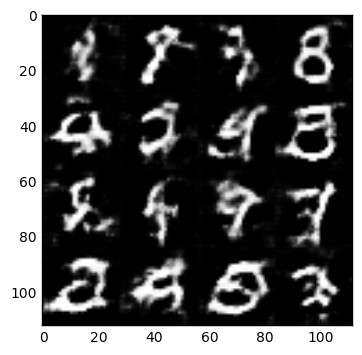

Epoch 1/2... Discriminator Loss: 1.2157... Generator Loss: 1.0090
Epoch 1/2... Discriminator Loss: 1.2416... Generator Loss: 0.6405
Epoch 1/2... Discriminator Loss: 1.1558... Generator Loss: 1.0330
Epoch 1/2... Discriminator Loss: 1.3113... Generator Loss: 0.6068
Epoch 1/2... Discriminator Loss: 1.7367... Generator Loss: 0.3593
Epoch 1/2... Discriminator Loss: 1.1460... Generator Loss: 0.9874
Epoch 1/2... Discriminator Loss: 1.2772... Generator Loss: 0.8053
Epoch 1/2... Discriminator Loss: 1.1879... Generator Loss: 1.4545
Epoch 1/2... Discriminator Loss: 1.4850... Generator Loss: 0.4958
Epoch 1/2... Discriminator Loss: 1.1412... Generator Loss: 0.8143


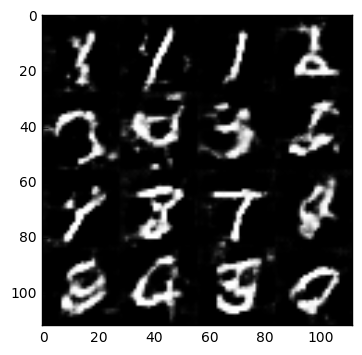

Epoch 1/2... Discriminator Loss: 1.1517... Generator Loss: 1.3004
Epoch 1/2... Discriminator Loss: 1.3080... Generator Loss: 0.6876
Epoch 1/2... Discriminator Loss: 1.2889... Generator Loss: 1.7375
Epoch 1/2... Discriminator Loss: 1.2096... Generator Loss: 0.7508
Epoch 1/2... Discriminator Loss: 1.2493... Generator Loss: 1.5613
Epoch 1/2... Discriminator Loss: 1.6009... Generator Loss: 1.8082
Epoch 1/2... Discriminator Loss: 1.5056... Generator Loss: 0.4885
Epoch 1/2... Discriminator Loss: 1.2344... Generator Loss: 1.3479
Epoch 1/2... Discriminator Loss: 1.1339... Generator Loss: 0.9124
Epoch 1/2... Discriminator Loss: 1.3526... Generator Loss: 0.6182


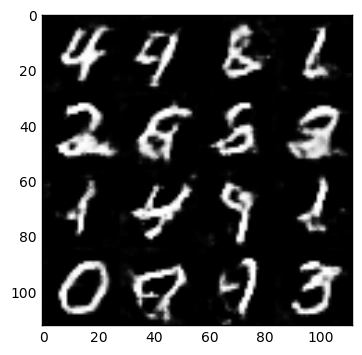

Epoch 1/2... Discriminator Loss: 1.1910... Generator Loss: 1.1589
Epoch 1/2... Discriminator Loss: 1.3277... Generator Loss: 0.5384
Epoch 1/2... Discriminator Loss: 1.2038... Generator Loss: 1.3263
Epoch 1/2... Discriminator Loss: 1.4149... Generator Loss: 0.5466
Epoch 1/2... Discriminator Loss: 1.5588... Generator Loss: 0.4233
Epoch 1/2... Discriminator Loss: 1.3932... Generator Loss: 0.7234
Epoch 1/2... Discriminator Loss: 1.3440... Generator Loss: 1.6500
Epoch 1/2... Discriminator Loss: 1.2756... Generator Loss: 0.6291
Epoch 1/2... Discriminator Loss: 1.1854... Generator Loss: 0.9294
Epoch 1/2... Discriminator Loss: 1.1135... Generator Loss: 0.8176


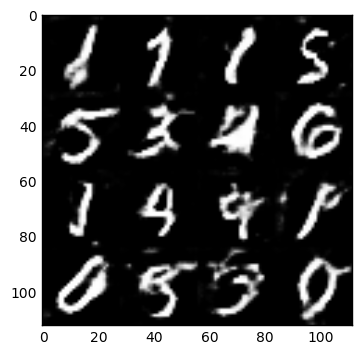

Epoch 1/2... Discriminator Loss: 1.4745... Generator Loss: 0.4937
Epoch 1/2... Discriminator Loss: 1.3580... Generator Loss: 1.3397
Epoch 1/2... Discriminator Loss: 1.1590... Generator Loss: 1.1262
Epoch 1/2... Discriminator Loss: 1.3877... Generator Loss: 2.0038
Epoch 1/2... Discriminator Loss: 1.9611... Generator Loss: 0.2809
Epoch 1/2... Discriminator Loss: 1.1619... Generator Loss: 1.4634
Epoch 1/2... Discriminator Loss: 2.2423... Generator Loss: 2.7913
Epoch 1/2... Discriminator Loss: 1.3145... Generator Loss: 1.0415
Epoch 1/2... Discriminator Loss: 1.6049... Generator Loss: 2.0495
Epoch 1/2... Discriminator Loss: 1.1787... Generator Loss: 1.1966


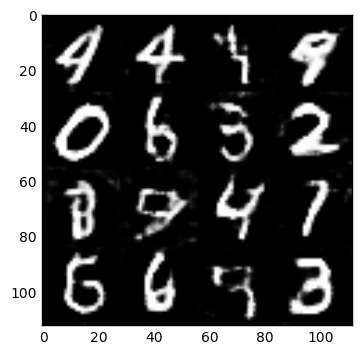

Epoch 1/2... Discriminator Loss: 1.2285... Generator Loss: 0.7795
Epoch 1/2... Discriminator Loss: 1.5120... Generator Loss: 1.7993
Epoch 1/2... Discriminator Loss: 1.4684... Generator Loss: 2.0263
Epoch 1/2... Discriminator Loss: 1.1855... Generator Loss: 1.0921
Epoch 1/2... Discriminator Loss: 1.1367... Generator Loss: 1.1366
Epoch 1/2... Discriminator Loss: 1.4799... Generator Loss: 0.4497
Epoch 1/2... Discriminator Loss: 2.9568... Generator Loss: 3.7464
Epoch 1/2... Discriminator Loss: 1.4626... Generator Loss: 0.6289
Epoch 1/2... Discriminator Loss: 1.4664... Generator Loss: 0.5251
Epoch 1/2... Discriminator Loss: 1.2110... Generator Loss: 0.7547


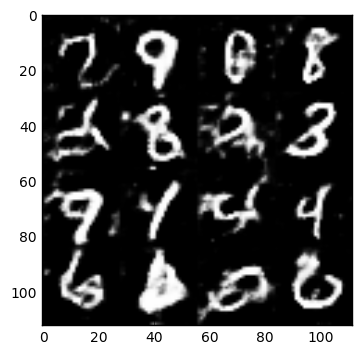

Epoch 1/2... Discriminator Loss: 1.2197... Generator Loss: 1.0805
Epoch 1/2... Discriminator Loss: 1.3568... Generator Loss: 2.0379
Epoch 1/2... Discriminator Loss: 1.4089... Generator Loss: 0.5432
Epoch 1/2... Discriminator Loss: 1.8295... Generator Loss: 0.3397
Epoch 1/2... Discriminator Loss: 1.8309... Generator Loss: 0.3185
Epoch 1/2... Discriminator Loss: 1.0281... Generator Loss: 0.9488
Epoch 1/2... Discriminator Loss: 1.5528... Generator Loss: 2.2047
Epoch 1/2... Discriminator Loss: 0.9931... Generator Loss: 1.4051
Epoch 1/2... Discriminator Loss: 1.1799... Generator Loss: 0.7721
Epoch 1/2... Discriminator Loss: 1.3909... Generator Loss: 0.5435


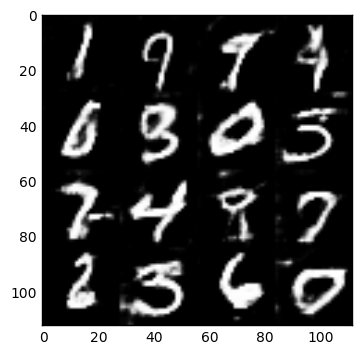

Epoch 1/2... Discriminator Loss: 1.2196... Generator Loss: 0.7914
Epoch 1/2... Discriminator Loss: 1.0155... Generator Loss: 0.9983
Epoch 1/2... Discriminator Loss: 1.3472... Generator Loss: 0.5749
Epoch 2/2... Discriminator Loss: 1.5719... Generator Loss: 0.4582
Epoch 2/2... Discriminator Loss: 1.4366... Generator Loss: 1.8583
Epoch 2/2... Discriminator Loss: 1.0356... Generator Loss: 1.0798
Epoch 2/2... Discriminator Loss: 1.2441... Generator Loss: 0.7166
Epoch 2/2... Discriminator Loss: 1.1807... Generator Loss: 0.8964
Epoch 2/2... Discriminator Loss: 1.5660... Generator Loss: 0.4187
Epoch 2/2... Discriminator Loss: 1.1737... Generator Loss: 1.6992


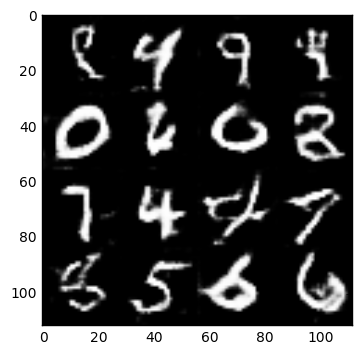

Epoch 2/2... Discriminator Loss: 1.0557... Generator Loss: 1.2700
Epoch 2/2... Discriminator Loss: 1.2766... Generator Loss: 0.6774
Epoch 2/2... Discriminator Loss: 1.0822... Generator Loss: 0.9787
Epoch 2/2... Discriminator Loss: 0.9898... Generator Loss: 1.3105
Epoch 2/2... Discriminator Loss: 1.1924... Generator Loss: 1.1641
Epoch 2/2... Discriminator Loss: 1.5768... Generator Loss: 0.5176
Epoch 2/2... Discriminator Loss: 1.3079... Generator Loss: 0.6014
Epoch 2/2... Discriminator Loss: 1.1615... Generator Loss: 0.7343
Epoch 2/2... Discriminator Loss: 1.0848... Generator Loss: 1.1724
Epoch 2/2... Discriminator Loss: 1.2165... Generator Loss: 0.8423


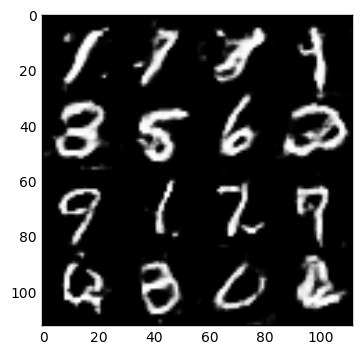

Epoch 2/2... Discriminator Loss: 1.1318... Generator Loss: 0.9753
Epoch 2/2... Discriminator Loss: 1.1667... Generator Loss: 0.7042
Epoch 2/2... Discriminator Loss: 1.1610... Generator Loss: 0.9999
Epoch 2/2... Discriminator Loss: 1.3558... Generator Loss: 0.5381
Epoch 2/2... Discriminator Loss: 1.2817... Generator Loss: 0.6074
Epoch 2/2... Discriminator Loss: 1.3070... Generator Loss: 0.5866
Epoch 2/2... Discriminator Loss: 1.0710... Generator Loss: 1.3674
Epoch 2/2... Discriminator Loss: 1.6031... Generator Loss: 0.4764
Epoch 2/2... Discriminator Loss: 1.7217... Generator Loss: 0.3902
Epoch 2/2... Discriminator Loss: 1.4138... Generator Loss: 0.5870


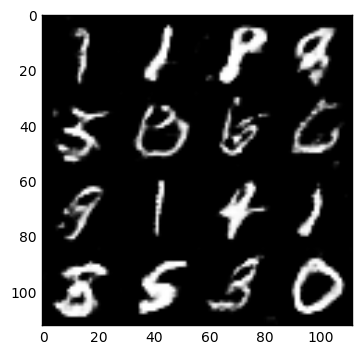

Epoch 2/2... Discriminator Loss: 1.5948... Generator Loss: 0.5530
Epoch 2/2... Discriminator Loss: 1.3333... Generator Loss: 0.5606
Epoch 2/2... Discriminator Loss: 1.3603... Generator Loss: 0.5482
Epoch 2/2... Discriminator Loss: 1.2029... Generator Loss: 0.8566
Epoch 2/2... Discriminator Loss: 1.1091... Generator Loss: 0.8488
Epoch 2/2... Discriminator Loss: 1.1587... Generator Loss: 1.0919
Epoch 2/2... Discriminator Loss: 1.2775... Generator Loss: 0.6537
Epoch 2/2... Discriminator Loss: 1.4727... Generator Loss: 0.4870
Epoch 2/2... Discriminator Loss: 0.8207... Generator Loss: 1.3303
Epoch 2/2... Discriminator Loss: 0.7635... Generator Loss: 1.5141


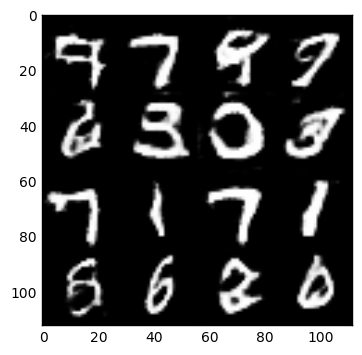

Epoch 2/2... Discriminator Loss: 1.3092... Generator Loss: 0.6367
Epoch 2/2... Discriminator Loss: 1.0681... Generator Loss: 2.2538
Epoch 2/2... Discriminator Loss: 0.9002... Generator Loss: 1.2165
Epoch 2/2... Discriminator Loss: 0.9750... Generator Loss: 1.3617
Epoch 2/2... Discriminator Loss: 1.1318... Generator Loss: 0.8514
Epoch 2/2... Discriminator Loss: 0.9024... Generator Loss: 1.3503
Epoch 2/2... Discriminator Loss: 1.3642... Generator Loss: 0.6306
Epoch 2/2... Discriminator Loss: 1.0412... Generator Loss: 1.1974
Epoch 2/2... Discriminator Loss: 1.5036... Generator Loss: 1.9490
Epoch 2/2... Discriminator Loss: 0.9902... Generator Loss: 1.2915


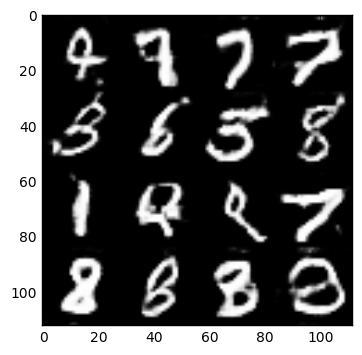

Epoch 2/2... Discriminator Loss: 1.0109... Generator Loss: 1.0576
Epoch 2/2... Discriminator Loss: 1.3519... Generator Loss: 0.6149
Epoch 2/2... Discriminator Loss: 0.9646... Generator Loss: 1.0539
Epoch 2/2... Discriminator Loss: 1.1429... Generator Loss: 1.4862
Epoch 2/2... Discriminator Loss: 0.8225... Generator Loss: 1.6485
Epoch 2/2... Discriminator Loss: 1.6280... Generator Loss: 0.4739
Epoch 2/2... Discriminator Loss: 1.1328... Generator Loss: 1.7547
Epoch 2/2... Discriminator Loss: 0.9401... Generator Loss: 1.2558
Epoch 2/2... Discriminator Loss: 1.0384... Generator Loss: 2.0674
Epoch 2/2... Discriminator Loss: 1.0498... Generator Loss: 1.2256


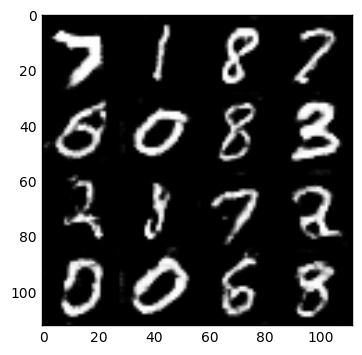

Epoch 2/2... Discriminator Loss: 1.2671... Generator Loss: 1.5938
Epoch 2/2... Discriminator Loss: 1.2287... Generator Loss: 0.7029
Epoch 2/2... Discriminator Loss: 1.0604... Generator Loss: 0.9461
Epoch 2/2... Discriminator Loss: 1.1273... Generator Loss: 1.6966
Epoch 2/2... Discriminator Loss: 1.1113... Generator Loss: 0.8055
Epoch 2/2... Discriminator Loss: 0.8835... Generator Loss: 1.4944
Epoch 2/2... Discriminator Loss: 1.9192... Generator Loss: 0.3907
Epoch 2/2... Discriminator Loss: 0.8652... Generator Loss: 1.2755
Epoch 2/2... Discriminator Loss: 1.2521... Generator Loss: 1.8619
Epoch 2/2... Discriminator Loss: 1.1207... Generator Loss: 0.7778


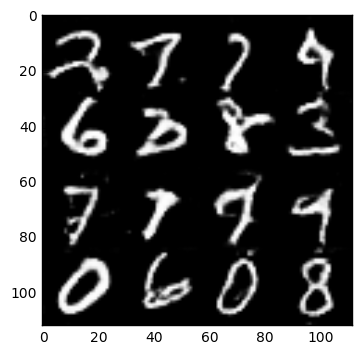

Epoch 2/2... Discriminator Loss: 1.0135... Generator Loss: 0.9764
Epoch 2/2... Discriminator Loss: 1.0336... Generator Loss: 1.0905
Epoch 2/2... Discriminator Loss: 1.3415... Generator Loss: 2.0807
Epoch 2/2... Discriminator Loss: 1.8643... Generator Loss: 2.8039
Epoch 2/2... Discriminator Loss: 1.3698... Generator Loss: 0.6022
Epoch 2/2... Discriminator Loss: 1.2497... Generator Loss: 0.7180
Epoch 2/2... Discriminator Loss: 1.0912... Generator Loss: 1.7209
Epoch 2/2... Discriminator Loss: 1.1577... Generator Loss: 0.7602
Epoch 2/2... Discriminator Loss: 1.0579... Generator Loss: 0.9233
Epoch 2/2... Discriminator Loss: 1.6389... Generator Loss: 0.4778


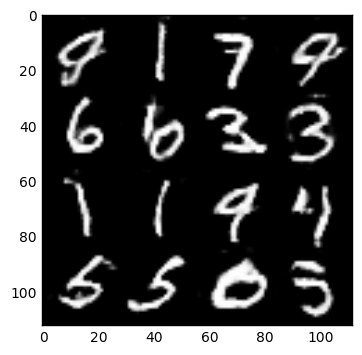

Epoch 2/2... Discriminator Loss: 0.9161... Generator Loss: 1.1101
Epoch 2/2... Discriminator Loss: 0.9662... Generator Loss: 1.3683
Epoch 2/2... Discriminator Loss: 1.0824... Generator Loss: 0.9632
Epoch 2/2... Discriminator Loss: 0.9380... Generator Loss: 2.1395
Epoch 2/2... Discriminator Loss: 0.9789... Generator Loss: 1.0066
Epoch 2/2... Discriminator Loss: 1.0391... Generator Loss: 0.9857
Epoch 2/2... Discriminator Loss: 1.2167... Generator Loss: 0.7265
Epoch 2/2... Discriminator Loss: 1.1708... Generator Loss: 0.8166
Epoch 2/2... Discriminator Loss: 1.0969... Generator Loss: 0.8307
Epoch 2/2... Discriminator Loss: 1.0876... Generator Loss: 0.9378


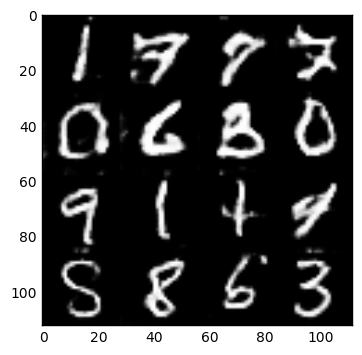

Epoch 2/2... Discriminator Loss: 1.0247... Generator Loss: 0.8785
Epoch 2/2... Discriminator Loss: 0.9199... Generator Loss: 1.0997
Epoch 2/2... Discriminator Loss: 0.8835... Generator Loss: 1.0848
Epoch 2/2... Discriminator Loss: 0.7593... Generator Loss: 1.9587
Epoch 2/2... Discriminator Loss: 0.8543... Generator Loss: 1.7498
Epoch 2/2... Discriminator Loss: 0.7042... Generator Loss: 1.6974
Epoch 2/2... Discriminator Loss: 0.9016... Generator Loss: 1.1179


In [17]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.7951... Generator Loss: 3.3891
Epoch 1/1... Discriminator Loss: 1.0978... Generator Loss: 1.0081
Epoch 1/1... Discriminator Loss: 1.5803... Generator Loss: 3.1596
Epoch 1/1... Discriminator Loss: 0.9013... Generator Loss: 1.2308
Epoch 1/1... Discriminator Loss: 0.7929... Generator Loss: 1.3283
Epoch 1/1... Discriminator Loss: 1.2181... Generator Loss: 2.7143
Epoch 1/1... Discriminator Loss: 1.0457... Generator Loss: 2.0081
Epoch 1/1... Discriminator Loss: 0.9199... Generator Loss: 2.0228
Epoch 1/1... Discriminator Loss: 1.0943... Generator Loss: 2.2053
Epoch 1/1... Discriminator Loss: 1.0832... Generator Loss: 1.2704


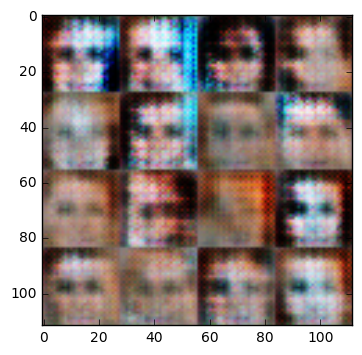

Epoch 1/1... Discriminator Loss: 1.5244... Generator Loss: 0.8193
Epoch 1/1... Discriminator Loss: 1.4661... Generator Loss: 2.0585
Epoch 1/1... Discriminator Loss: 1.4297... Generator Loss: 1.1329
Epoch 1/1... Discriminator Loss: 1.2033... Generator Loss: 0.9155
Epoch 1/1... Discriminator Loss: 1.2070... Generator Loss: 0.7836
Epoch 1/1... Discriminator Loss: 1.3950... Generator Loss: 0.6043
Epoch 1/1... Discriminator Loss: 1.4167... Generator Loss: 0.7473
Epoch 1/1... Discriminator Loss: 1.5323... Generator Loss: 1.2620
Epoch 1/1... Discriminator Loss: 2.8209... Generator Loss: 0.1172
Epoch 1/1... Discriminator Loss: 1.3417... Generator Loss: 0.8446


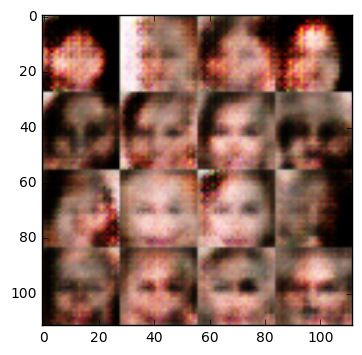

Epoch 1/1... Discriminator Loss: 1.3373... Generator Loss: 0.8467
Epoch 1/1... Discriminator Loss: 2.0209... Generator Loss: 1.8091
Epoch 1/1... Discriminator Loss: 1.3493... Generator Loss: 0.8065
Epoch 1/1... Discriminator Loss: 1.3993... Generator Loss: 0.7355
Epoch 1/1... Discriminator Loss: 1.3567... Generator Loss: 0.8019
Epoch 1/1... Discriminator Loss: 1.2342... Generator Loss: 0.7996
Epoch 1/1... Discriminator Loss: 1.4406... Generator Loss: 0.7320
Epoch 1/1... Discriminator Loss: 1.2955... Generator Loss: 1.0460
Epoch 1/1... Discriminator Loss: 1.1551... Generator Loss: 1.2832
Epoch 1/1... Discriminator Loss: 1.0691... Generator Loss: 0.7425


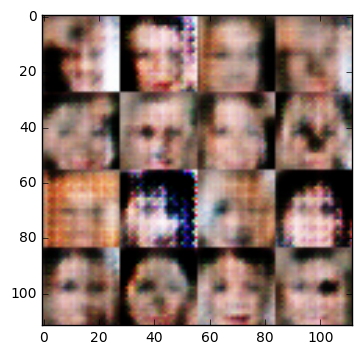

Epoch 1/1... Discriminator Loss: 2.5054... Generator Loss: 2.3926
Epoch 1/1... Discriminator Loss: 1.4620... Generator Loss: 0.8761
Epoch 1/1... Discriminator Loss: 1.3061... Generator Loss: 1.2115
Epoch 1/1... Discriminator Loss: 1.3670... Generator Loss: 0.7493
Epoch 1/1... Discriminator Loss: 1.4124... Generator Loss: 0.8385
Epoch 1/1... Discriminator Loss: 1.3922... Generator Loss: 0.8074
Epoch 1/1... Discriminator Loss: 1.4605... Generator Loss: 1.1722
Epoch 1/1... Discriminator Loss: 1.1851... Generator Loss: 0.9462
Epoch 1/1... Discriminator Loss: 1.2789... Generator Loss: 1.1732
Epoch 1/1... Discriminator Loss: 1.3984... Generator Loss: 0.8824


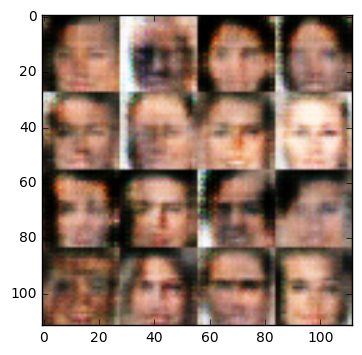

Epoch 1/1... Discriminator Loss: 1.4773... Generator Loss: 0.5271
Epoch 1/1... Discriminator Loss: 1.1984... Generator Loss: 0.7916
Epoch 1/1... Discriminator Loss: 1.5752... Generator Loss: 0.6281
Epoch 1/1... Discriminator Loss: 1.3460... Generator Loss: 0.8036
Epoch 1/1... Discriminator Loss: 1.3637... Generator Loss: 0.6193
Epoch 1/1... Discriminator Loss: 1.3941... Generator Loss: 1.1521
Epoch 1/1... Discriminator Loss: 1.2825... Generator Loss: 1.1880
Epoch 1/1... Discriminator Loss: 1.3569... Generator Loss: 0.6898
Epoch 1/1... Discriminator Loss: 1.5053... Generator Loss: 0.4890
Epoch 1/1... Discriminator Loss: 1.2742... Generator Loss: 1.0492


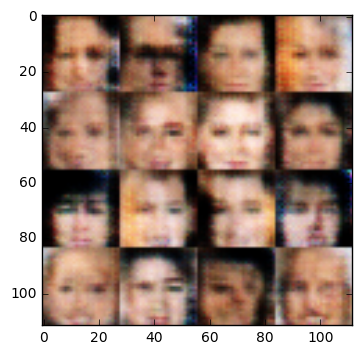

Epoch 1/1... Discriminator Loss: 1.3725... Generator Loss: 0.8043
Epoch 1/1... Discriminator Loss: 1.4913... Generator Loss: 0.4701
Epoch 1/1... Discriminator Loss: 1.1093... Generator Loss: 1.0921
Epoch 1/1... Discriminator Loss: 1.3222... Generator Loss: 0.9027
Epoch 1/1... Discriminator Loss: 0.9168... Generator Loss: 1.1690
Epoch 1/1... Discriminator Loss: 1.4188... Generator Loss: 0.8155
Epoch 1/1... Discriminator Loss: 1.3336... Generator Loss: 0.7982
Epoch 1/1... Discriminator Loss: 1.3442... Generator Loss: 0.8879
Epoch 1/1... Discriminator Loss: 1.3752... Generator Loss: 0.7027
Epoch 1/1... Discriminator Loss: 1.4282... Generator Loss: 0.7754


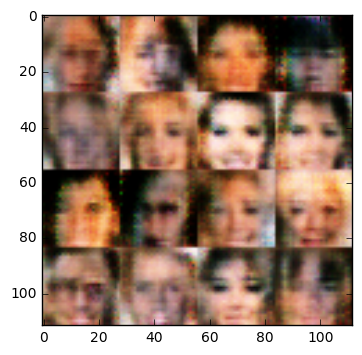

Epoch 1/1... Discriminator Loss: 1.2577... Generator Loss: 0.9598
Epoch 1/1... Discriminator Loss: 1.4680... Generator Loss: 0.8542
Epoch 1/1... Discriminator Loss: 1.3942... Generator Loss: 0.7668
Epoch 1/1... Discriminator Loss: 1.3980... Generator Loss: 0.7569
Epoch 1/1... Discriminator Loss: 1.4491... Generator Loss: 0.9691
Epoch 1/1... Discriminator Loss: 1.4036... Generator Loss: 0.7068
Epoch 1/1... Discriminator Loss: 1.3000... Generator Loss: 0.9858
Epoch 1/1... Discriminator Loss: 1.4151... Generator Loss: 0.8375
Epoch 1/1... Discriminator Loss: 1.3634... Generator Loss: 0.6904
Epoch 1/1... Discriminator Loss: 1.3735... Generator Loss: 0.8897


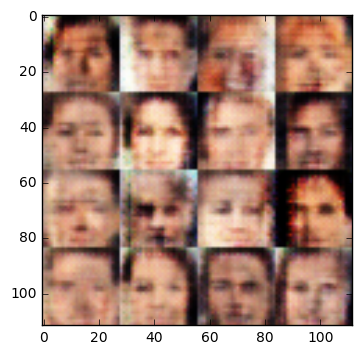

Epoch 1/1... Discriminator Loss: 1.4083... Generator Loss: 0.8305
Epoch 1/1... Discriminator Loss: 1.3816... Generator Loss: 0.7153
Epoch 1/1... Discriminator Loss: 1.5056... Generator Loss: 0.7118
Epoch 1/1... Discriminator Loss: 1.3959... Generator Loss: 0.9048
Epoch 1/1... Discriminator Loss: 1.3657... Generator Loss: 0.5864
Epoch 1/1... Discriminator Loss: 1.4662... Generator Loss: 0.7403
Epoch 1/1... Discriminator Loss: 1.3271... Generator Loss: 0.8606
Epoch 1/1... Discriminator Loss: 1.3725... Generator Loss: 0.8991
Epoch 1/1... Discriminator Loss: 1.3412... Generator Loss: 0.7491
Epoch 1/1... Discriminator Loss: 1.3962... Generator Loss: 0.8438


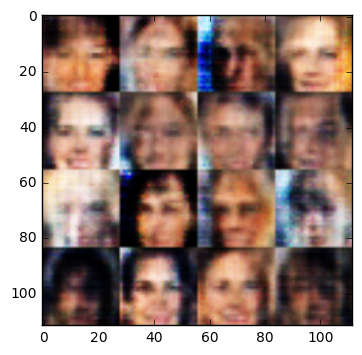

Epoch 1/1... Discriminator Loss: 1.2052... Generator Loss: 1.1887
Epoch 1/1... Discriminator Loss: 1.4832... Generator Loss: 0.5093
Epoch 1/1... Discriminator Loss: 1.1474... Generator Loss: 1.1044
Epoch 1/1... Discriminator Loss: 1.2269... Generator Loss: 0.9922
Epoch 1/1... Discriminator Loss: 1.7295... Generator Loss: 1.2635
Epoch 1/1... Discriminator Loss: 1.3539... Generator Loss: 0.8029
Epoch 1/1... Discriminator Loss: 1.3932... Generator Loss: 0.6077
Epoch 1/1... Discriminator Loss: 1.5168... Generator Loss: 0.5189
Epoch 1/1... Discriminator Loss: 1.3833... Generator Loss: 0.9512
Epoch 1/1... Discriminator Loss: 1.2875... Generator Loss: 0.7361


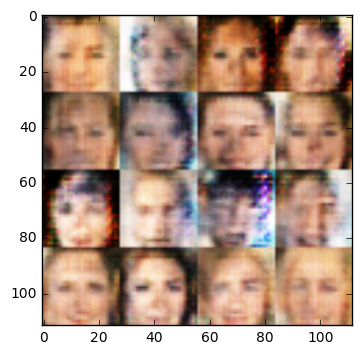

Epoch 1/1... Discriminator Loss: 1.3472... Generator Loss: 0.8409
Epoch 1/1... Discriminator Loss: 1.2688... Generator Loss: 0.7791
Epoch 1/1... Discriminator Loss: 1.4881... Generator Loss: 0.5899
Epoch 1/1... Discriminator Loss: 1.4107... Generator Loss: 0.7704
Epoch 1/1... Discriminator Loss: 1.3234... Generator Loss: 0.8737
Epoch 1/1... Discriminator Loss: 1.4592... Generator Loss: 0.7408
Epoch 1/1... Discriminator Loss: 1.4296... Generator Loss: 0.7621
Epoch 1/1... Discriminator Loss: 1.3627... Generator Loss: 0.9671
Epoch 1/1... Discriminator Loss: 1.4201... Generator Loss: 0.8827
Epoch 1/1... Discriminator Loss: 1.4206... Generator Loss: 0.9285


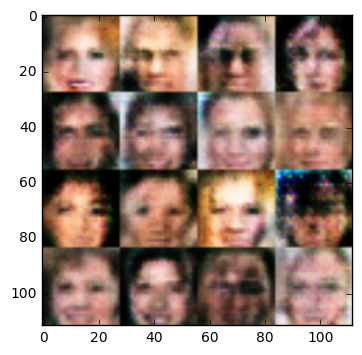

Epoch 1/1... Discriminator Loss: 1.3779... Generator Loss: 0.6756
Epoch 1/1... Discriminator Loss: 1.3023... Generator Loss: 0.7585
Epoch 1/1... Discriminator Loss: 1.4372... Generator Loss: 0.7453
Epoch 1/1... Discriminator Loss: 1.4147... Generator Loss: 0.8845
Epoch 1/1... Discriminator Loss: 1.4418... Generator Loss: 0.8762
Epoch 1/1... Discriminator Loss: 1.3261... Generator Loss: 0.7318
Epoch 1/1... Discriminator Loss: 1.4571... Generator Loss: 0.7986
Epoch 1/1... Discriminator Loss: 1.4208... Generator Loss: 0.8643
Epoch 1/1... Discriminator Loss: 1.4028... Generator Loss: 0.7685
Epoch 1/1... Discriminator Loss: 1.4012... Generator Loss: 0.8114


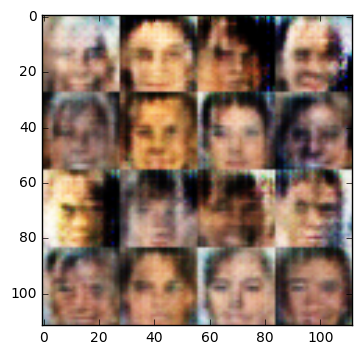

Epoch 1/1... Discriminator Loss: 1.4008... Generator Loss: 0.7416
Epoch 1/1... Discriminator Loss: 1.2792... Generator Loss: 0.7740
Epoch 1/1... Discriminator Loss: 1.3624... Generator Loss: 0.8363
Epoch 1/1... Discriminator Loss: 1.3812... Generator Loss: 0.8307
Epoch 1/1... Discriminator Loss: 1.4535... Generator Loss: 1.0215
Epoch 1/1... Discriminator Loss: 1.3287... Generator Loss: 0.7381
Epoch 1/1... Discriminator Loss: 1.3029... Generator Loss: 0.7439
Epoch 1/1... Discriminator Loss: 1.3628... Generator Loss: 0.9911
Epoch 1/1... Discriminator Loss: 1.2131... Generator Loss: 0.9173
Epoch 1/1... Discriminator Loss: 1.3169... Generator Loss: 1.0009


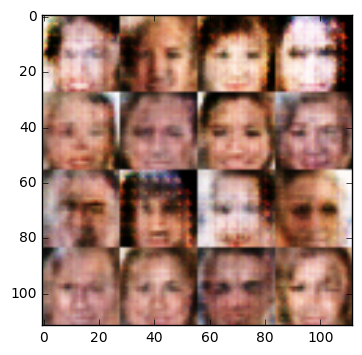

Epoch 1/1... Discriminator Loss: 1.3880... Generator Loss: 0.7058
Epoch 1/1... Discriminator Loss: 1.3531... Generator Loss: 0.8760
Epoch 1/1... Discriminator Loss: 1.5646... Generator Loss: 0.3802
Epoch 1/1... Discriminator Loss: 1.3334... Generator Loss: 0.9340
Epoch 1/1... Discriminator Loss: 1.2334... Generator Loss: 1.0529
Epoch 1/1... Discriminator Loss: 1.3869... Generator Loss: 1.0465
Epoch 1/1... Discriminator Loss: 1.4328... Generator Loss: 0.7871
Epoch 1/1... Discriminator Loss: 1.4560... Generator Loss: 0.6783
Epoch 1/1... Discriminator Loss: 1.4597... Generator Loss: 0.6402
Epoch 1/1... Discriminator Loss: 1.3209... Generator Loss: 0.8284


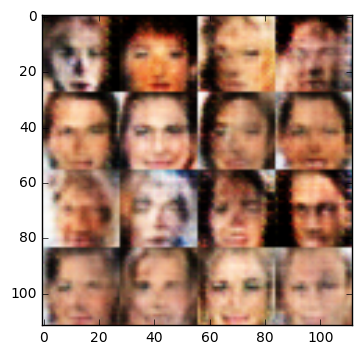

Epoch 1/1... Discriminator Loss: 1.3562... Generator Loss: 0.8372
Epoch 1/1... Discriminator Loss: 1.4047... Generator Loss: 0.8040
Epoch 1/1... Discriminator Loss: 1.4155... Generator Loss: 0.5756
Epoch 1/1... Discriminator Loss: 1.3514... Generator Loss: 1.1823
Epoch 1/1... Discriminator Loss: 1.2565... Generator Loss: 1.1252
Epoch 1/1... Discriminator Loss: 1.2612... Generator Loss: 0.9913
Epoch 1/1... Discriminator Loss: 1.3981... Generator Loss: 0.6936
Epoch 1/1... Discriminator Loss: 1.4160... Generator Loss: 0.9142
Epoch 1/1... Discriminator Loss: 1.3473... Generator Loss: 0.6906
Epoch 1/1... Discriminator Loss: 1.2634... Generator Loss: 1.0851


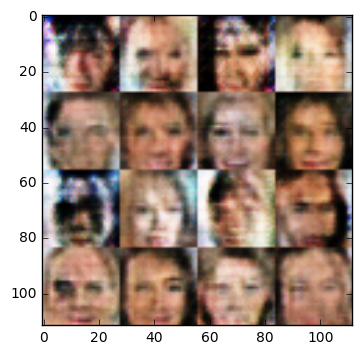

Epoch 1/1... Discriminator Loss: 1.3597... Generator Loss: 0.9386
Epoch 1/1... Discriminator Loss: 1.3241... Generator Loss: 0.9956
Epoch 1/1... Discriminator Loss: 1.3842... Generator Loss: 0.8039
Epoch 1/1... Discriminator Loss: 1.4481... Generator Loss: 1.0576
Epoch 1/1... Discriminator Loss: 1.3132... Generator Loss: 0.7095
Epoch 1/1... Discriminator Loss: 1.3452... Generator Loss: 1.0364
Epoch 1/1... Discriminator Loss: 1.3912... Generator Loss: 0.8965
Epoch 1/1... Discriminator Loss: 1.2210... Generator Loss: 0.8079
Epoch 1/1... Discriminator Loss: 1.3527... Generator Loss: 1.0070
Epoch 1/1... Discriminator Loss: 1.3344... Generator Loss: 0.8048


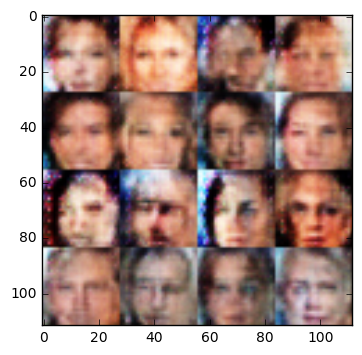

Epoch 1/1... Discriminator Loss: 1.3787... Generator Loss: 0.8031
Epoch 1/1... Discriminator Loss: 1.3523... Generator Loss: 0.8257
Epoch 1/1... Discriminator Loss: 1.3505... Generator Loss: 0.7585
Epoch 1/1... Discriminator Loss: 1.4505... Generator Loss: 0.7659
Epoch 1/1... Discriminator Loss: 1.3333... Generator Loss: 0.9635
Epoch 1/1... Discriminator Loss: 1.2682... Generator Loss: 0.8792
Epoch 1/1... Discriminator Loss: 1.3735... Generator Loss: 1.0652
Epoch 1/1... Discriminator Loss: 1.4137... Generator Loss: 0.6599
Epoch 1/1... Discriminator Loss: 1.7917... Generator Loss: 1.2194
Epoch 1/1... Discriminator Loss: 1.2542... Generator Loss: 0.8541


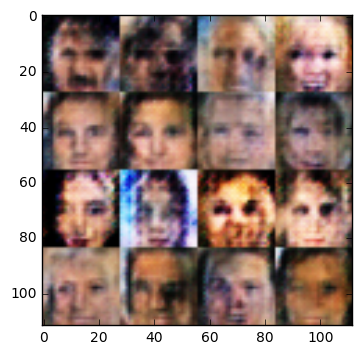

Epoch 1/1... Discriminator Loss: 1.3600... Generator Loss: 0.6209
Epoch 1/1... Discriminator Loss: 1.3469... Generator Loss: 0.8936
Epoch 1/1... Discriminator Loss: 1.4231... Generator Loss: 0.6840
Epoch 1/1... Discriminator Loss: 1.5796... Generator Loss: 1.2517
Epoch 1/1... Discriminator Loss: 1.2579... Generator Loss: 0.8855
Epoch 1/1... Discriminator Loss: 1.4322... Generator Loss: 0.8691
Epoch 1/1... Discriminator Loss: 1.3621... Generator Loss: 0.9107
Epoch 1/1... Discriminator Loss: 1.3221... Generator Loss: 0.7648
Epoch 1/1... Discriminator Loss: 1.4636... Generator Loss: 0.7111
Epoch 1/1... Discriminator Loss: 1.3844... Generator Loss: 0.7675


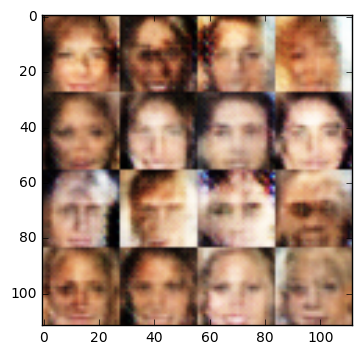

Epoch 1/1... Discriminator Loss: 1.3451... Generator Loss: 0.5985
Epoch 1/1... Discriminator Loss: 1.3873... Generator Loss: 1.0917
Epoch 1/1... Discriminator Loss: 1.4914... Generator Loss: 0.7431
Epoch 1/1... Discriminator Loss: 1.4522... Generator Loss: 0.8579
Epoch 1/1... Discriminator Loss: 1.4043... Generator Loss: 0.8352
Epoch 1/1... Discriminator Loss: 1.3277... Generator Loss: 0.7814
Epoch 1/1... Discriminator Loss: 1.3415... Generator Loss: 0.8329
Epoch 1/1... Discriminator Loss: 1.3531... Generator Loss: 0.8065
Epoch 1/1... Discriminator Loss: 1.4185... Generator Loss: 0.7696
Epoch 1/1... Discriminator Loss: 1.3117... Generator Loss: 0.7353


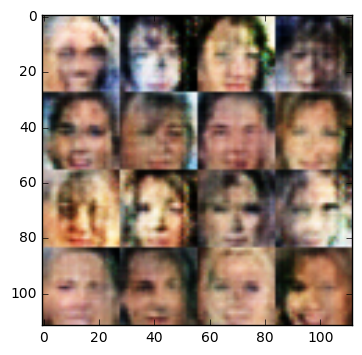

Epoch 1/1... Discriminator Loss: 1.4486... Generator Loss: 0.6336
Epoch 1/1... Discriminator Loss: 1.3804... Generator Loss: 0.8506
Epoch 1/1... Discriminator Loss: 1.3577... Generator Loss: 0.8157
Epoch 1/1... Discriminator Loss: 1.3697... Generator Loss: 0.8045
Epoch 1/1... Discriminator Loss: 1.4429... Generator Loss: 0.8148
Epoch 1/1... Discriminator Loss: 1.3425... Generator Loss: 0.8267
Epoch 1/1... Discriminator Loss: 1.3098... Generator Loss: 0.6903
Epoch 1/1... Discriminator Loss: 1.3430... Generator Loss: 0.6822
Epoch 1/1... Discriminator Loss: 1.3220... Generator Loss: 0.8125
Epoch 1/1... Discriminator Loss: 1.2972... Generator Loss: 1.2422


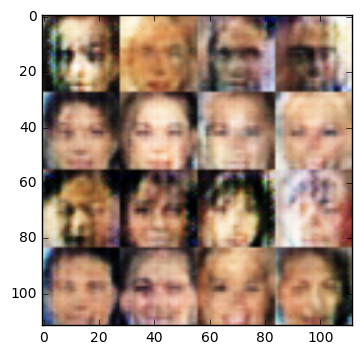

Epoch 1/1... Discriminator Loss: 1.4296... Generator Loss: 0.6946
Epoch 1/1... Discriminator Loss: 1.3465... Generator Loss: 0.8088
Epoch 1/1... Discriminator Loss: 1.3515... Generator Loss: 1.2206
Epoch 1/1... Discriminator Loss: 1.3204... Generator Loss: 0.7772
Epoch 1/1... Discriminator Loss: 1.4245... Generator Loss: 0.7585
Epoch 1/1... Discriminator Loss: 1.3300... Generator Loss: 0.7512
Epoch 1/1... Discriminator Loss: 1.3959... Generator Loss: 0.8172
Epoch 1/1... Discriminator Loss: 1.2569... Generator Loss: 0.8965
Epoch 1/1... Discriminator Loss: 1.3384... Generator Loss: 0.9195
Epoch 1/1... Discriminator Loss: 1.3857... Generator Loss: 0.8375


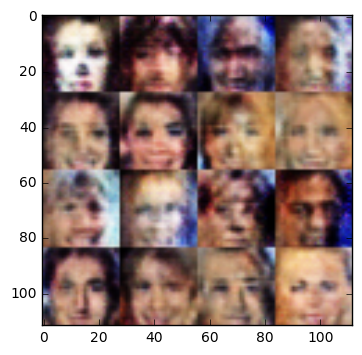

Epoch 1/1... Discriminator Loss: 1.3821... Generator Loss: 0.6590
Epoch 1/1... Discriminator Loss: 1.3146... Generator Loss: 0.8196
Epoch 1/1... Discriminator Loss: 1.3391... Generator Loss: 0.8170
Epoch 1/1... Discriminator Loss: 1.3704... Generator Loss: 0.7506
Epoch 1/1... Discriminator Loss: 1.3623... Generator Loss: 0.8039
Epoch 1/1... Discriminator Loss: 1.3050... Generator Loss: 0.7092
Epoch 1/1... Discriminator Loss: 1.5452... Generator Loss: 1.2176
Epoch 1/1... Discriminator Loss: 1.3322... Generator Loss: 0.7939
Epoch 1/1... Discriminator Loss: 1.4084... Generator Loss: 1.1428
Epoch 1/1... Discriminator Loss: 1.3212... Generator Loss: 0.8035


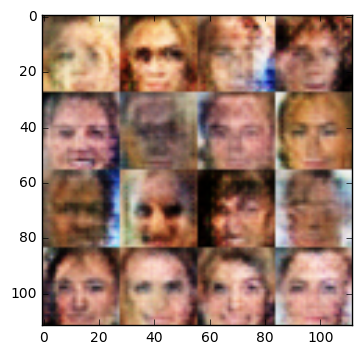

Epoch 1/1... Discriminator Loss: 1.3915... Generator Loss: 1.0476
Epoch 1/1... Discriminator Loss: 1.4125... Generator Loss: 0.7763
Epoch 1/1... Discriminator Loss: 1.2767... Generator Loss: 0.7357
Epoch 1/1... Discriminator Loss: 1.3816... Generator Loss: 0.8306
Epoch 1/1... Discriminator Loss: 1.4382... Generator Loss: 0.8057
Epoch 1/1... Discriminator Loss: 1.2928... Generator Loss: 0.9276
Epoch 1/1... Discriminator Loss: 1.3727... Generator Loss: 0.7368
Epoch 1/1... Discriminator Loss: 1.3990... Generator Loss: 0.8572
Epoch 1/1... Discriminator Loss: 1.3612... Generator Loss: 0.8070
Epoch 1/1... Discriminator Loss: 1.3662... Generator Loss: 0.8502


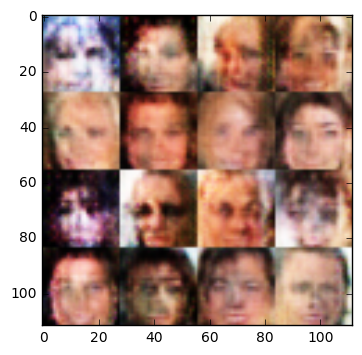

Epoch 1/1... Discriminator Loss: 1.3610... Generator Loss: 0.8306
Epoch 1/1... Discriminator Loss: 1.3669... Generator Loss: 0.7773
Epoch 1/1... Discriminator Loss: 1.4781... Generator Loss: 1.1285
Epoch 1/1... Discriminator Loss: 1.2875... Generator Loss: 0.8381
Epoch 1/1... Discriminator Loss: 1.3551... Generator Loss: 0.6064
Epoch 1/1... Discriminator Loss: 1.3247... Generator Loss: 1.0469
Epoch 1/1... Discriminator Loss: 1.2255... Generator Loss: 0.8044
Epoch 1/1... Discriminator Loss: 1.3379... Generator Loss: 0.7813
Epoch 1/1... Discriminator Loss: 1.2998... Generator Loss: 0.9442
Epoch 1/1... Discriminator Loss: 1.3883... Generator Loss: 0.7225


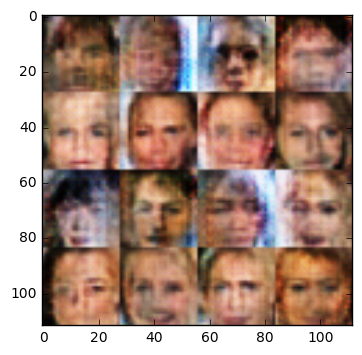

Epoch 1/1... Discriminator Loss: 1.2946... Generator Loss: 0.7738
Epoch 1/1... Discriminator Loss: 1.5034... Generator Loss: 0.6901
Epoch 1/1... Discriminator Loss: 1.3186... Generator Loss: 0.8743
Epoch 1/1... Discriminator Loss: 1.3113... Generator Loss: 0.7714
Epoch 1/1... Discriminator Loss: 1.4647... Generator Loss: 0.8384
Epoch 1/1... Discriminator Loss: 1.3227... Generator Loss: 0.7076
Epoch 1/1... Discriminator Loss: 1.2728... Generator Loss: 0.6482
Epoch 1/1... Discriminator Loss: 1.3993... Generator Loss: 0.9291
Epoch 1/1... Discriminator Loss: 1.3457... Generator Loss: 0.9460
Epoch 1/1... Discriminator Loss: 1.4475... Generator Loss: 0.7347


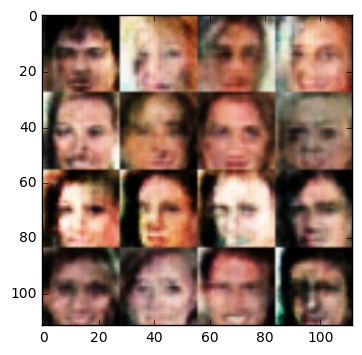

Epoch 1/1... Discriminator Loss: 1.3762... Generator Loss: 0.7973
Epoch 1/1... Discriminator Loss: 1.3240... Generator Loss: 0.9174
Epoch 1/1... Discriminator Loss: 1.3775... Generator Loss: 0.7419
Epoch 1/1... Discriminator Loss: 1.4050... Generator Loss: 0.9701
Epoch 1/1... Discriminator Loss: 1.1985... Generator Loss: 0.6832
Epoch 1/1... Discriminator Loss: 1.3189... Generator Loss: 0.8553
Epoch 1/1... Discriminator Loss: 1.3213... Generator Loss: 0.8686
Epoch 1/1... Discriminator Loss: 1.3142... Generator Loss: 0.7020
Epoch 1/1... Discriminator Loss: 1.5066... Generator Loss: 0.6750
Epoch 1/1... Discriminator Loss: 1.3366... Generator Loss: 0.7731


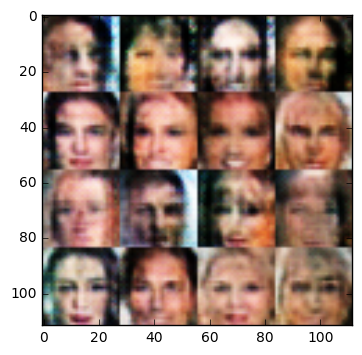

Epoch 1/1... Discriminator Loss: 1.3735... Generator Loss: 0.5890
Epoch 1/1... Discriminator Loss: 1.2965... Generator Loss: 1.0270
Epoch 1/1... Discriminator Loss: 1.4151... Generator Loss: 0.8412
Epoch 1/1... Discriminator Loss: 1.4192... Generator Loss: 1.0180
Epoch 1/1... Discriminator Loss: 1.4004... Generator Loss: 0.8064
Epoch 1/1... Discriminator Loss: 1.3219... Generator Loss: 0.8140
Epoch 1/1... Discriminator Loss: 1.4434... Generator Loss: 0.6789
Epoch 1/1... Discriminator Loss: 1.4229... Generator Loss: 0.8129
Epoch 1/1... Discriminator Loss: 1.3674... Generator Loss: 0.8078
Epoch 1/1... Discriminator Loss: 1.3343... Generator Loss: 0.7228


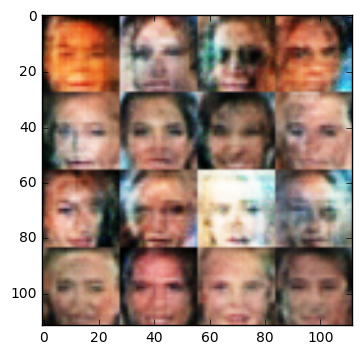

Epoch 1/1... Discriminator Loss: 1.3033... Generator Loss: 0.7395
Epoch 1/1... Discriminator Loss: 1.3559... Generator Loss: 0.8285
Epoch 1/1... Discriminator Loss: 1.3380... Generator Loss: 0.7207
Epoch 1/1... Discriminator Loss: 1.4174... Generator Loss: 0.6916
Epoch 1/1... Discriminator Loss: 1.4194... Generator Loss: 0.8913
Epoch 1/1... Discriminator Loss: 1.3586... Generator Loss: 0.7675
Epoch 1/1... Discriminator Loss: 1.3366... Generator Loss: 0.8849
Epoch 1/1... Discriminator Loss: 1.3671... Generator Loss: 0.8142
Epoch 1/1... Discriminator Loss: 1.2882... Generator Loss: 0.8773
Epoch 1/1... Discriminator Loss: 1.3293... Generator Loss: 0.7698


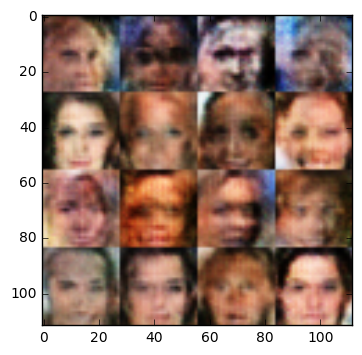

Epoch 1/1... Discriminator Loss: 1.4170... Generator Loss: 0.8321
Epoch 1/1... Discriminator Loss: 1.3280... Generator Loss: 0.8682
Epoch 1/1... Discriminator Loss: 1.3134... Generator Loss: 0.6465
Epoch 1/1... Discriminator Loss: 1.3433... Generator Loss: 0.8627
Epoch 1/1... Discriminator Loss: 1.2596... Generator Loss: 0.8411
Epoch 1/1... Discriminator Loss: 1.3977... Generator Loss: 0.9276
Epoch 1/1... Discriminator Loss: 1.3850... Generator Loss: 0.9551
Epoch 1/1... Discriminator Loss: 1.3089... Generator Loss: 0.8583
Epoch 1/1... Discriminator Loss: 1.2794... Generator Loss: 1.0410
Epoch 1/1... Discriminator Loss: 1.2497... Generator Loss: 0.7714


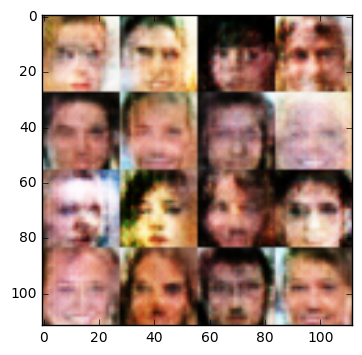

Epoch 1/1... Discriminator Loss: 1.3773... Generator Loss: 0.8909
Epoch 1/1... Discriminator Loss: 1.3380... Generator Loss: 0.8436
Epoch 1/1... Discriminator Loss: 1.2800... Generator Loss: 0.8403
Epoch 1/1... Discriminator Loss: 1.4631... Generator Loss: 0.7409
Epoch 1/1... Discriminator Loss: 1.4379... Generator Loss: 0.8247
Epoch 1/1... Discriminator Loss: 1.3284... Generator Loss: 0.8393
Epoch 1/1... Discriminator Loss: 1.3917... Generator Loss: 0.9061
Epoch 1/1... Discriminator Loss: 1.2882... Generator Loss: 0.9005
Epoch 1/1... Discriminator Loss: 1.5219... Generator Loss: 0.8988
Epoch 1/1... Discriminator Loss: 1.2625... Generator Loss: 0.7240


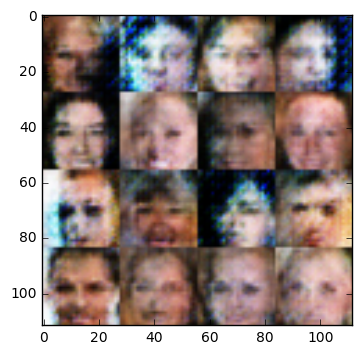

Epoch 1/1... Discriminator Loss: 1.5371... Generator Loss: 0.6699
Epoch 1/1... Discriminator Loss: 1.4086... Generator Loss: 0.8801
Epoch 1/1... Discriminator Loss: 1.3238... Generator Loss: 0.7488
Epoch 1/1... Discriminator Loss: 1.3506... Generator Loss: 1.2702
Epoch 1/1... Discriminator Loss: 1.2189... Generator Loss: 0.8337
Epoch 1/1... Discriminator Loss: 1.4055... Generator Loss: 0.8131
Epoch 1/1... Discriminator Loss: 1.5369... Generator Loss: 0.6017
Epoch 1/1... Discriminator Loss: 1.3920... Generator Loss: 0.8437
Epoch 1/1... Discriminator Loss: 1.3314... Generator Loss: 0.7900
Epoch 1/1... Discriminator Loss: 1.3601... Generator Loss: 0.6937


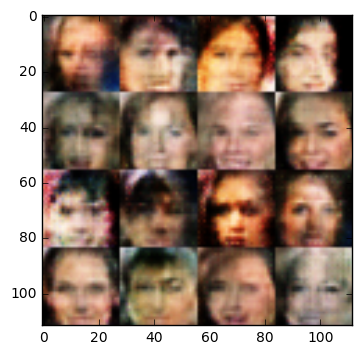

Epoch 1/1... Discriminator Loss: 1.3797... Generator Loss: 0.7184
Epoch 1/1... Discriminator Loss: 1.3085... Generator Loss: 0.8895
Epoch 1/1... Discriminator Loss: 1.4070... Generator Loss: 1.1055
Epoch 1/1... Discriminator Loss: 1.3574... Generator Loss: 0.7195
Epoch 1/1... Discriminator Loss: 1.4358... Generator Loss: 0.7731
Epoch 1/1... Discriminator Loss: 1.3857... Generator Loss: 0.8676
Epoch 1/1... Discriminator Loss: 1.3743... Generator Loss: 0.8150
Epoch 1/1... Discriminator Loss: 1.3225... Generator Loss: 0.7883
Epoch 1/1... Discriminator Loss: 1.3481... Generator Loss: 0.6811
Epoch 1/1... Discriminator Loss: 1.3081... Generator Loss: 0.7247


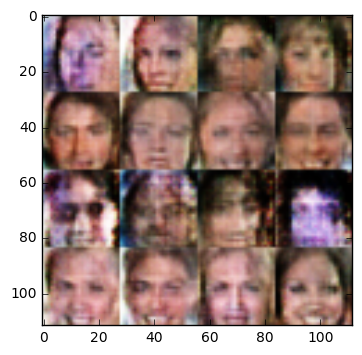

Epoch 1/1... Discriminator Loss: 1.4934... Generator Loss: 1.4720
Epoch 1/1... Discriminator Loss: 1.3648... Generator Loss: 0.8808
Epoch 1/1... Discriminator Loss: 1.3938... Generator Loss: 0.8422
Epoch 1/1... Discriminator Loss: 1.4391... Generator Loss: 0.5569
Epoch 1/1... Discriminator Loss: 1.3413... Generator Loss: 0.7171
Epoch 1/1... Discriminator Loss: 1.3556... Generator Loss: 0.8426


In [18]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.